In [39]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [40]:
from tensorflow import compat

class DAE(object):

	"""
	Denoising autoencoder. Gaussian noise is added. The scale and standard deviation
	of it are noise_scale and noise_std, respectively.
	"""

	def __init__(self, n_feature, n_hidden, noise_scale, noise_std, reg_lamda = 0.01):

		self.n_hidden = n_hidden
		self.n_feature = n_feature
		self.reg_lamda = reg_lamda
		self.noise_scale = noise_scale
		self.noise_std = noise_std

		self.data = compat.v1.placeholder(shape = [None, n_feature],
		                           dtype = compat.v1.float64)
		self.noise = self.noise_scale * compat.v1.random_normal([n_feature], dtype = compat.v1.float64,
		                                               stddev = self.noise_std)
		data_with_noise = self.data + self.noise

		self.weight_encoder = compat.v1.get_variable(name = 'weight_encoder',
			                    shape = [self.n_feature, self.n_hidden],
			                    dtype = compat.v1.float64)
		self.bias_encoder = compat.v1.Variable(compat.v1.zeros([self.n_hidden],
			                                      dtype = compat.v1.float64),
		                                name = 'bias_encoder')

		weight_decoder = compat.v1.get_variable(name = 'weight_decoder',
			                    shape = [self.n_hidden, self.n_feature],
			                    dtype = compat.v1.float64)
		bias_decoder = compat.v1.Variable(compat.v1.zeros([self.n_feature], dtype = compat.v1.float64),
			                           name = 'bias_decoder')

		with compat.v1.name_scope('Encoder'):
			data_encoded = compat.v1.add(compat.v1.matmul(data_with_noise, self.weight_encoder),
				                  self.bias_encoder)
			data_encoded = compat.v1.nn.tanh(data_encoded)

		with compat.v1.name_scope('Decoder'):
			data_recons = compat.v1.add(compat.v1.matmul(data_encoded, weight_decoder),
				                 bias_decoder)
			self.data_recons = compat.v1.tanh(data_recons)

		with compat.v1.name_scope('Loss'):
			diff = self.data_recons - self.data
			self.loss_mse = 0.5 * compat.v1.reduce_mean(compat.v1.reduce_sum(diff**2, axis = 1))
			loss_reg = compat.v1.reduce_sum(compat.v1.sqrt(compat.v1.reduce_sum(self.weight_encoder ** 2, axis = 1)))
			self.loss_reg = self.reg_lamda * loss_reg
			self.l2_loss = compat.v1.nn.l2_loss(weight_decoder) * 1E-3

			self.loss = self.loss_mse + self.loss_reg + self.l2_loss

		with compat.v1.name_scope('weight_vector'):
			self.weight_vector = compat.v1.reduce_sum(self.weight_encoder ** 2, axis = 1)


class unbalanced_DAE(object):

	"""
	An unbalanced version of DAE. the differences is that a weight pos_weight is added
	to the MSE reconstruction loss for positive examples. For this purpose, the labels
	of the examples are used.
	"""

	def __init__(self, n_feature, n_hidden, noise_scale, noise_std,
	             posi_weight = 1.0, reg_lamda = 0.00):

		self.n_hidden = n_hidden
		self.n_feature = n_feature
		self.reg_lamda = reg_lamda
		self.noise_scale = noise_scale
		self.noise_std = noise_std
		self.posi_weight = posi_weight

		self.data = compat.v1.placeholder(shape = [None, n_feature], dtype = compat.v1.float64)
		self.label = compat.v1.placeholder(shape = [None, 1], dtype = compat.v1.float64)
		self.noise = self.noise_scale * compat.v1.random_normal([n_feature], dtype = compat.v1.float64,
		                                                  stddev = self.noise_std)
		data_with_noise = self.data + self.noise

		self.weight_encoder = compat.v1.get_variable(name = 'weight_encoder',
			                    shape = [self.n_feature, self.n_hidden],
			                    dtype = compat.v1.float64)
		self.bias_encoder = compat.v1.Variable(compat.v1.zeros([self.n_hidden],
			                                      dtype = compat.v1.float64),
		                                name = 'bias_encoder')

		weight_decoder = compat.v1.get_variable(name = 'weight_decoder',
			                    shape = [self.n_hidden, self.n_feature],
			                    dtype = compat.v1.float64)
		bias_decoder = compat.v1.Variable(compat.v1.zeros([self.n_feature], dtype = compat.v1.float64),
			                           name = 'bias_decoder')

		with compat.v1.name_scope('Encoder'):
			data_encoded = compat.v1.add(compat.v1.matmul(data_with_noise, self.weight_encoder),
				                  self.bias_encoder)
			data_encoded = compat.v1.nn.sigmoid(data_encoded)

		with compat.v1.name_scope('Decoder'):
			data_recons = compat.v1.add(compat.v1.matmul(data_encoded, weight_decoder),
				                 bias_decoder)
			self.data_recons = compat.v1.nn.sigmoid(data_recons)

		with compat.v1.name_scope('Loss'):
			diff = self.data_recons - self.data
			weights = self.label * (posi_weight -1) + 1
			weights = compat.v1.reshape(weights, shape = [-1])
			self.loss_mse = 0.5 * compat.v1.reduce_mean(compat.v1.reduce_sum(diff**2, axis = 1) * weights)
			loss_reg = compat.v1.reduce_sum(compat.v1.sqrt(compat.v1.reduce_sum(self.weight_encoder ** 2, axis = 1)))
			self.loss_reg = self.reg_lamda * loss_reg
			self.l2_loss = compat.v1.nn.l2_loss(weight_decoder) * 1E-3

			self.loss = self.loss_mse + self.loss_reg + self.l2_loss

		with compat.v1.name_scope('weight_vector'):
			self.weight_vector = compat.v1.reduce_sum(self.weight_encoder ** 2, axis = 1)

In [41]:
from tensorflow import compat
import numpy as np
from sklearn.model_selection import train_test_split

def P_R_F1(confusion_matrix):

    category = confusion_matrix.shape[0]
    precision = []
    recall = []
    f1 = []
    for i in range (category):
        TP = confusion_matrix[i,i]

        precsion_temp = TP/np.sum(confusion_matrix[:,i])
        recall_temp = TP/np.sum(confusion_matrix[i,:])
        f1_temp = 2*precsion_temp*recall_temp/(precsion_temp + recall_temp)

        precision.append(precsion_temp)
        recall.append(recall_temp)
        f1.append(f1_temp)

    return precision, recall, f1

# shaping labels to one-hot vectors for trainning
def label_coding(label, batch_size, category):
    new_label = compat.v1.cast(label, dtype = compat.v1.int32)
    new_label = compat.v1.reshape(new_label, [batch_size, 1])
    new_label = compat.v1.one_hot(new_label, depth = category)
    return compat.v1.reshape(new_label, [batch_size, category])

# get next batch of data and label
def next_batch(filename, batch_size, conf, buffer_size = 0):

    len_feature = conf.len_feature
    len_label = conf.len_label
    num_classes = conf.num_classes
    one_hot_encoding = conf.one_hot_encoding

    def read_data(examples):
        features = {"features": compat.v1.FixedLenFeature([len_feature], compat.v1.float32),
                    "label_2": compat.v1.FixedLenFeature([len_label], compat.v1.float32),
                    "label_10": compat.v1.FixedLenFeature([len_label], compat.v1.float32)}
        parsed_features = compat.v1.parse_single_example(examples, features)
        return parsed_features['features'], parsed_features['label_2'], \
               parsed_features['label_10']

    data = compat.v1.data.TFRecordDataset(filename)
    data = data.map(read_data)
    if buffer_size != 0:
        data = data.shuffle(buffer_size = buffer_size)
    data = data.repeat()
    data = data.batch(batch_size)
    iterator = data.make_one_shot_iterator()
    next_data, next_label_2, next_label_10 = iterator.get_next()

    if one_hot_encoding == True:
        if num_classes == 2:
            next_label_2 = label_coding(next_label_2, batch_size,
                                        num_classes)
        else:
            next_label_10 = label_coding(next_label_10, batch_size,
                                         num_classes)

    return next_data, next_label_2, next_label_10


def trans_dataset(file_tfr, file_txt, num_examples, num_classes):
    with compat.v1.Session() as sess:
        all_data, all_label = next_batch(file_tfr, num_examples)
        all_label = label_coding(all_label, num_examples, num_classes)

        record = np.concatenate([sess.run(all_data), sess.run(all_label)], axis = 1)
        np.savetxt(file_txt, record, fmt = '%.6e')

def split_dataset(file_train, file_test, k, file_folder_new): # k is refer to k_fold

    trainset = np.loadtxt(file_train)
    testset = np.loadtxt(file_test)
    dataset = np.concatenate((trainset, testset))

    for i in range(k - 1):
        trainset, testset = train_test_split(dataset, test_size = 1/(k - i))
        dataset = trainset
        np.savetxt(file_folder_new + str(i) + '.txt', testset)

    np.savetxt(file_folder_new + str(k - 1) + '.txt', trainset)

def get_dataset(file_folder, index_test, indices_train):

    testset = np.loadtxt(file_folder + str(index_test) + '.txt')

    count = 0
    for other in indices_train:
        temp = np.loadtxt(file_folder + str(other) + '.txt')

        if count == 0:
            trainset = temp
        else:
            trainset = np.concatenate((trainset, temp))

        count += 1

    return trainset, testset

def parse_pos_neg(dataset):

    label = dataset[:, -1]

    record_posi = []
    record_neg = []

    records_len = dataset.shape[-1]
    records_num = dataset.shape[0]

    for index in range(records_num):
        record = dataset[index, :]
        record = np.reshape(record, (1, records_len))
        if label[index] == 0.:
            record_posi.append(record)
        else:
            record_neg.append(record)

    posi = np.concatenate(record_posi)
    neg = np.concatenate(record_neg)

    return posi, neg

"""
if __name__ == '__main__':

    num_train = 125973
    num_test = 22543
    file_folder = 'normalized/'

    num_classes = 2
    trans_dataset(file_folder + 'train+.tfrecords', file_folder + 'train2.txt', num_train, num_classes)
    trans_dataset(file_folder + 'test+.tfrecords', file_folder + 'test2.txt', num_test, num_classes)

    num_classes = 5
    trans_dataset(file_folder + 'train5.tfrecords', file_folder + 'train5.txt', num_train, num_classes)
    trans_dataset(file_folder + 'test5.tfrecords', file_folder + 'test5.txt', num_test, num_classes)

    file_folder_new = file_folder + 'cross_validation_5/'

    file_train = file_folder + 'train5.txt'
    file_test = file_folder +'test5.txt'
    split_dataset(file_train, file_test, k =10, file_folder_new = file_folder_new)

    dataset = np.loadtxt(file_folder +'train_new.txt')
    #dataset = [file_folder + str(x + 1) + '_train.csv' for x in range(4)]
    posi, neg = parse_pos_neg(dataset)

    np.savetxt(file_folder + 'train_posi.txt',posi )
    np.savetxt(file_folder + 'train_neg.txt', neg)
    """

"\nif __name__ == '__main__':\n\n    num_train = 125973\n    num_test = 22543\n    file_folder = 'normalized/'\n\n    num_classes = 2\n    trans_dataset(file_folder + 'train+.tfrecords', file_folder + 'train2.txt', num_train, num_classes)\n    trans_dataset(file_folder + 'test+.tfrecords', file_folder + 'test2.txt', num_test, num_classes)\n\n    num_classes = 5\n    trans_dataset(file_folder + 'train5.tfrecords', file_folder + 'train5.txt', num_train, num_classes)\n    trans_dataset(file_folder + 'test5.tfrecords', file_folder + 'test5.txt', num_test, num_classes)\n\n    file_folder_new = file_folder + 'cross_validation_5/'\n\n    file_train = file_folder + 'train5.txt'\n    file_test = file_folder +'test5.txt'\n    split_dataset(file_train, file_test, k =10, file_folder_new = file_folder_new)\n\n    dataset = np.loadtxt(file_folder +'train_new.txt')\n    #dataset = [file_folder + str(x + 1) + '_train.csv' for x in range(4)]\n    posi, neg = parse_pos_neg(dataset)\n\n    np.savetxt(fil

In [42]:
import time
from tensorflow import compat
import numpy as np
#from autoencoders import DAE, unbalanced_DAE
#from utils import next_batch, P_R_F1

compat.v1.reset_default_graph()

# system parameters

class Configures(object):

	def __init__(self):
        # parameter of records
		self.len_feature = 202
		self.len_label = 1
		#self.num_classes = 2
		self.num_classes = 10
		self.one_hot_encoding = False
		self.num_records_train = 1625628
		self.num_records_test = 508012

        # parameters for training
		self.batch_size = 256
		self.batch_size_test = 2048
		self.training_epochs = 2
		self.learn_rate_start = 1E-4

		self.batch_train = self.num_records_train//self.batch_size
		self.batch_test = self.num_records_test//self.batch_size_test

n_hidden = 64
noise_scale = 0.
noise_std = 0.1
conf = Configures()

# training op
with compat.v1.Session() as sess:

	#AE = DAE(conf.len_feature, n_hidden, noise_scale, noise_std, reg_lamda = 0.001)
	AE = unbalanced_DAE(conf.len_feature, n_hidden, noise_scale, noise_std, posi_weight = 3.5,
		                reg_lamda = 0.001)

	global_step = compat.v1.Variable(0, name = 'training_steps', trainable = False)
	learn_rate = compat.v1.train.exponential_decay(conf.learn_rate_start, global_step, 2000, 0.96, staircase=True)
	update_ops = compat.v1.get_collection(compat.v1.GraphKeys.UPDATE_OPS)
	with compat.v1.control_dependencies(update_ops):
		optimizer = compat.v1.train.AdamOptimizer(conf.learn_rate_start)
		grads_and_vars = optimizer.compute_gradients(AE.loss)
		grads_clipped = [(compat.v1.clip_by_value(grad, -5., 5.), var) for grad, var in grads_and_vars]
		train_op = optimizer.apply_gradients(grads_clipped, global_step = global_step)

	sess.run(compat.v1.global_variables_initializer())

	# Reading data
	file_train = ['../dataset/SGM-CNN/normalized/train.tfrecords', '../dataset/SGM-CNN/normalized/validation.tfrecords']
	file_test = '../dataset/SGM-CNN/normalized/test.tfrecords'
	train_data, train_label, _ = next_batch(file_train, conf.batch_size, conf, 150)
	test_data, test_label, _ = next_batch(file_test, conf.batch_size_test, conf)

	min_loss = 100.
	for epoch in range(conf.training_epochs):
		time_start = time.time()
		total_mse_loss = 0.
		total_loss = 0.
		total_reg_loss = 0.

		for step in range(conf.batch_train):
			data, label = sess.run([train_data, train_label])

			feed_dict = {AE.data: data, AE.label: label}
			_, loss, loss_mse, loss_reg = sess.run([train_op, AE.loss, AE.loss_mse, AE.loss_reg],
			                                        feed_dict = feed_dict)

			total_loss += loss
			total_mse_loss += loss_mse
			total_reg_loss += loss_reg

		time_train_end = time.time()
		test_loss = 0.
		test_loss_reg = 0.
		test_loss_mse = 0.

		for step in range(conf.batch_test):
			data, label = sess.run([test_data, test_label])

			feed_dict = {AE.data: data, AE.label: label}
			weights, loss, loss_mse, loss_reg = sess.run([AE.weight_vector, AE.loss, AE.loss_mse, AE.loss_reg],
			                                              feed_dict = feed_dict)
			test_loss += loss/conf.batch_test
			test_loss_mse += loss_mse/conf.batch_test
			test_loss_reg += loss_reg/conf.batch_test

		time_test_end = time.time()

		time_duration_train = int(time_train_end - time_start)
		time_duration_test = int(time_test_end - time_train_end)


		if test_loss < min_loss:
			min_loss = test_loss
			np.savetxt('../dataset/SGM-CNN/normalized/weights_new_3.5.txt', weights, fmt = "%.6E")

		print("Epoch:", "%d," % (epoch + 1),
			  "Loss on Train:", "{:.6f}".format(total_loss/(conf.batch_train)),
			  "mse on Train:", "{:.6f}".format(total_mse_loss/conf.batch_train),
			  "reg on Train:", "{:.6f}".format(total_reg_loss/conf.batch_train),
			  "Loss on Test:", "{:.6f}".format(test_loss),
			  "mse on Test:", "{:.6f}".format(test_loss_mse),
			  "reg on Test:", "{:.6f}".format(test_loss_reg))

		print(time_duration_train)
		print(time_duration_test)

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Epoch: 1, Loss on Train: 26.171487 mse on Train: 25.979220 reg on Train: 0.077158 Loss on Test: 22.507186 mse on Test: 22.232535 reg on Test: 0.090983
75
13
Epoch: 2, Loss on Train: 21.624054 mse

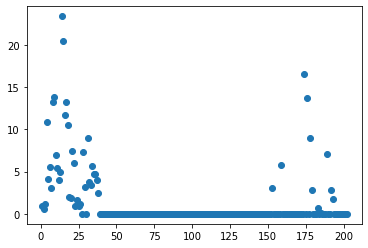

[13, 14, 173, 8, 175, 7, 16, 15, 3, 17, 177, 30]
stcpb
dtcpb
service_-
dload
service_dns
sload
dmeansz
smeansz
sttl
trans_depth
service_ftp-data
ct_ftp


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd5 in position 92: invalid continuation byte

<Figure size 432x288 with 0 Axes>

In [45]:
import heapq
import os
import re
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import compat
from pandas import read_csv

def get_indices(num_select, num_feature, file_weights):
	"""
	This function is to select maximum k features according to their
	weights.

	Pram:
		num_select: An interger, the number of the selected features
		num_feature: An interger, the number of the original features
		file_weights: A txt file storing a numpy array. Each row of the
		              array is the weight for a feature
	Return:
		a list containing the indices of selected features
	"""

	x = np.arange(1, num_feature + 1)
	y = np.loadtxt(file_weights)
	indices = heapq.nlargest(num_select, range(len(y)), y.take)
	plt.scatter(x, y)
	plt.show()
	plt.savefig('weights_dis.eps', format = 'eps')
	print(indices)

	return indices


def read_data(examples):
    features = {"features": compat.v1.FixedLenFeature([num_feature], compat.v1.float32),
                "label_2": compat.v1.FixedLenFeature([len_label], compat.v1.float32),
                "label_10": compat.v1.FixedLenFeature([len_label], compat.v1.float32)}
    parsed_features = compat.v1.parse_single_example(examples, features)
    return parsed_features['features'], parsed_features['label_2'], \
           parsed_features['label_10']


# get next batch of data and label
def next_batch(filename, num_examples):

    data = compat.v1.data.TFRecordDataset(filename)
    data = data.map(read_data)
    data = data.batch(num_examples)
    iterator = data.make_one_shot_iterator()
    next_data, next_label_2, next_label_10 = iterator.get_next()
    return next_data, next_label_2, next_label_10


def make_tfrecords(dataset, file_to_save):
	[features, label_2, label_10] = dataset

	with compat.v1.python_io.TFRecordWriter(file_to_save) as writer:
		for index in range(features.shape[0]):
			feature = {'features': compat.v1.train.Feature(float_list = compat.v1.train.FloatList(value = features[index, :])),
			           'label_2': compat.v1.train.Feature(float_list = compat.v1.train.FloatList(value = label_2[index, :])),
			           'label_10': compat.v1.train.Feature(float_list = compat.v1.train.FloatList(value = label_10[index, :]))}
			example = compat.v1.train.Example(features = compat.v1.train.Features(feature = feature))
			writer.write(example.SerializeToString())


def selection(data, indices):
	"""
	select the columns (indicating the features) according to the indices
	"""

	return data[:, indices]


def select_feature(file, num_examples, indices):
	"""
	The main function of feature selection.

	Params:
	  file: The .tfrecords file containing original data.包含原始数据的.tfrecords文件
	  num_examples: The number of examples in the file  文件中的记录数
	  indices: The indices of features to be selected  被选择特征的索引

	Return:
	  None
	  In the function, a new .tfrecords file with tail of 'selected'
	  will be created in the same folder with the original data
	"""

	with compat.v1.Session() as sess:
		data, label_2, label_10 = sess.run(next_batch(file, num_examples))

	data_select = selection(data, indices)

	file_name = file.split('\\')[-1] 
	file_tail = len('.tfrecords')
	file_to_save = file_name[:-1*file_tail] + '_select_' + str(len(indices)) + '.tfrecords'
	

	make_tfrecords([data_select, label_2, label_10], file_to_save)


def show_feature_name(indices): 
	""" 
	The function to convert indices to feature names

	Params:
	  indices:the indices of the features
	Return:
	  None. 
	  The name of features will be print
	"""

	#dirname = os.path.dirname(os.getcwd())
	#file = os.path.join(dirname, 'normalized/', '1_test.csv')
	file = os.path.join( 'normalized/', '1_test.csv')
	data = read_csv(file, index_col = 0)
	cols = data.columns

	for x in indices:
		print(cols[x])


if __name__ == '__main__':

	num_select = 12   #选择出来的特征数。The number of selected features
	num_feature = 202
	len_label = 1
	file_weights = '../dataset/SGM-CNN/normalized/weights_new_3.5.txt'

	indices = get_indices(num_select, num_feature, file_weights)
	#print(indices)
	show_feature_name(indices)

	dirname = os.path.dirname(os.getcwd())
	file_folder = os.path.join(dirname, 'normalized/')
	
	file_train = file_folder + 'train.tfrecords'
	file_valid = file_folder + 'validation.tfrecords'
	num_examples_train = 1778030
	num_examples_validation = 254005

	file_test = file_folder + 'test.tfrecords'
	num_examples_test = 508012

	
	select_feature(file_train, num_examples_train, indices)
	select_feature(file_valid, num_examples_validation, indices)
	select_feature(file_test, num_examples_test, indices)


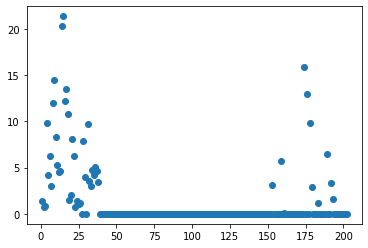

[14, 13, 173, 8, 16, 175, 15, 7, 17, 3, 177, 30]


[14, 13, 173, 8, 16, 175, 15, 7, 17, 3, 177, 30]

<Figure size 432x288 with 0 Axes>

In [7]:
get_indices(num_select, num_feature, file_weights)